# 2D ring resonator

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FRingResonator.ipynb). View this project in [Tidy3D Web App](https://tidy3d.simulation.cloud/workbench?taskId=4b6c5361-8274-4a9b-8d4d-e0c51f31ef6f).

This is a simple example of using Tidy3D to perform a 2D simulation of a ring resonator side coupled to a dielectric waveguide.

<img src="img/ring.png" alt="diagram" width="300"/>

With a center wavelength of 500 nm and 10 nm resolution, this is a challenging FDTD problem because of the large simulation size.  The simulation contains 2 million grid points to model the entire domain and 290,000 time steps to capture the resonance of the ring.

With Tidy3D, we perform the simulation in just a few minutes.

In [1]:
# standard python imports
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

# tidy3D import
import tidy3d.web as web
import tidy3d as td

## Initial setup

Our ring resonator will include a ring centered at (0,0) with a waveguide just above the ring spanning the x direction.

```    
                      (waveguide)      
                in -> ========== -> out
                           0
                      (resonator)
   ```

In [2]:
# define geometry
wg_width = 0.25
couple_width = 0.05
ring_radius = 3.5
ring_wg_width = 0.25
wg_spacing = 2.0
buffer = 2.0

# compute quantities based on geometry parameters
x_span = 2*wg_spacing + 2*ring_radius + 2*buffer
y_span = 2*ring_radius + 2*ring_wg_width + wg_width + couple_width + 2*buffer
wg_insert_x = ring_radius + wg_spacing
wg_center_y = ring_radius + ring_wg_width/2. + couple_width + wg_width/2.

In [3]:
# define pulse parameters
lambda0 = 0.5
freq0 = td.C_0 /lambda0
fwidth =  freq0 / 6
min_steps_per_wvl = 30
run_time_norm = 1e-13  # run time for normalization run without ring
run_time = 5e-12       # run time for simulation with ring

Define materials. [(docs)](https://docs.simulation.cloud/projects/tidy3d/en/latest/api.html#mediums)

In [4]:
n_bg = 1.0
n_solid = 1.5
background = td.Medium(permittivity=n_bg**2)
solid = td.Medium(permittivity=n_solid**2)

Define structures. [(docs)](https://docs.simulation.cloud/projects/tidy3d/en/latest/api.html#structures)


In [5]:
# background of entire domain (set explicitly as a box)
background_box = td.Structure(
    geometry=td.Box(
        center=[0, 0, 0],
        size=[td.inf, td.inf, td.inf],
    ),
    medium=background,
    name='background')

# waveguide
waveguide = td.Structure(
    geometry=td.Box(
        center=[0, wg_center_y, 0],
        size=[td.inf, wg_width, td.inf],
    ),
    medium=solid,
    name='waveguide')

# outside ring
outer_ring = td.Structure(
    geometry=td.Cylinder(
        center=[0,0,0],
        axis=2,
        radius=ring_radius+ring_wg_width/2.0,
        length=td.inf,
    ),
    medium=solid,
    name='outer_ring')

# inside ring fill
inner_ring = td.Structure(
    geometry=td.Cylinder(
        center=[0,0,0],
        axis=2,
        radius=ring_radius-ring_wg_width/2.0,
        length=td.inf,
    ),
    medium=background,
    name='inner_ring')

Compute and visualize the waveguide modes.

In [6]:
from tidy3d.plugins import ModeSolver

mode_plane = td.Box(
    center=[-wg_insert_x, wg_center_y, 0],
    size=[0, 2, td.inf],
)

sim_modesolver = td.Simulation(
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=lambda0),
    structures=[background_box, waveguide],
    run_time=1e-12,
)

mode_spec = td.ModeSpec(num_modes=2)
mode_solver = ModeSolver(simulation=sim_modesolver, plane=mode_plane, mode_spec=mode_spec, freqs=[freq0])
mode_data = mode_solver.solve()

[14:10:33] WARNING  No sources in simulation.                               ]8;id=746707;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=68571;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#421\421]8;;\

<Figure size 720x432 with 6 Axes>

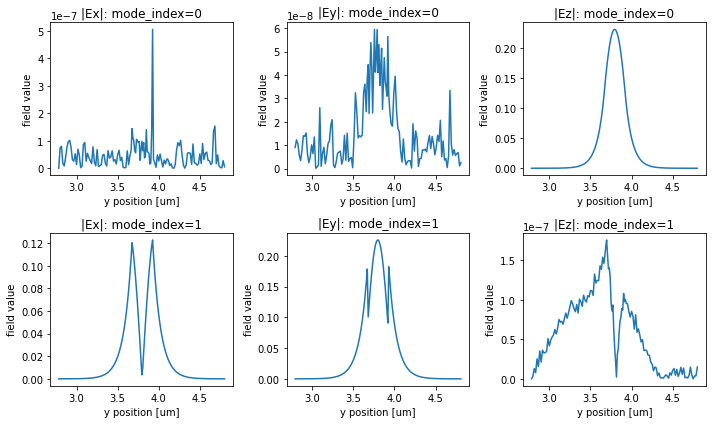

In [7]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, tight_layout=True, figsize=(10, 6))
mode_data.Ex.sel(mode_index=0).abs.plot(ax=ax1)
mode_data.Ey.sel(mode_index=0).abs.plot(ax=ax2)
mode_data.Ez.sel(mode_index=0).abs.plot(ax=ax3)
mode_data.Ex.sel(mode_index=1).abs.plot(ax=ax4)
mode_data.Ey.sel(mode_index=1).abs.plot(ax=ax5)
mode_data.Ez.sel(mode_index=1).abs.plot(ax=ax6)
ax1.set_title('|Ex|: mode_index=0')
ax2.set_title('|Ey|: mode_index=0')
ax3.set_title('|Ez|: mode_index=0')
ax4.set_title('|Ex|: mode_index=1')
ax5.set_title('|Ey|: mode_index=1')
ax6.set_title('|Ez|: mode_index=1')
plt.show()

From the above plots, we see that 

`mode_index=0` corresponds to exciting 0-th order TM mode (E=Ez) and 

`mode_index=1` corresponds to exciting 0-th order TE mode (E=Ey).

We can therefore switch the mode index accordingly based on our polarization.

Let's select Ey and create the source for it.

In [8]:
mode_source = td.ModeSource(
    size=mode_plane.size,
    center=mode_plane.center,
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    mode_spec=td.ModeSpec(num_modes=2),
    mode_index=1,
    direction='+'
)

In addition, let's monitor both the fields in plane as well as the output mode amplitudes into the fundamental TE mode.

In [9]:
# monitor steady state fields at central frequency over whole domain
field_monitor = td.FieldMonitor(
    center=[0, 0, 0],
    size=[td.inf, td.inf, 0],
    freqs=[freq0],
    name='field')

# monitor the mode amps on the output waveguide
lambdas_measure = np.linspace(0.4, 0.6, 1001)
freqs_measure = td.C_0 / lambdas_measure

mode_monitor = td.ModeMonitor(
    size=mode_plane.size,
    center=mode_plane.center,
    freqs=freqs_measure,
    mode_spec=td.ModeSpec(num_modes=2),
    name='mode'
)

# lets reset the center to the on the right hand side of the simulation though
mode_monitor = mode_monitor.copy(update=dict(center = [+wg_insert_x, wg_center_y, 0]))

Define simulation. [(docs)](https://docs.simulation.cloud/projects/tidy3d/en/latest/api.html#simulation)
To make the simulation 2D, we can just set the simulation size in one of the dimensions to be 0. However, note that we still have to define a grid size in that direction.

In [10]:
# create normalization simulation (no ring)
sim0 = td.Simulation(
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=lambda0),
    structures=[background_box, waveguide],
    sources=[mode_source],
    monitors=[field_monitor, mode_monitor],
    run_time = run_time_norm,
    boundary_spec=td.BoundarySpec.pml(x=True, y=True)
)

# create simulation (with ring)
sim = td.Simulation(
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=lambda0),
    structures=[background_box, waveguide, outer_ring, inner_ring],
    sources=[mode_source],
    monitors=[field_monitor, mode_monitor],
    run_time = run_time,
    boundary_spec=td.BoundarySpec.pml(x=True, y=True)
)

----
Visualize structure, source, and modes. [(docs)](https://docs.simulation.cloud/en/latest/howdoi.html#plot-data)

<Figure size 1296x432 with 4 Axes>

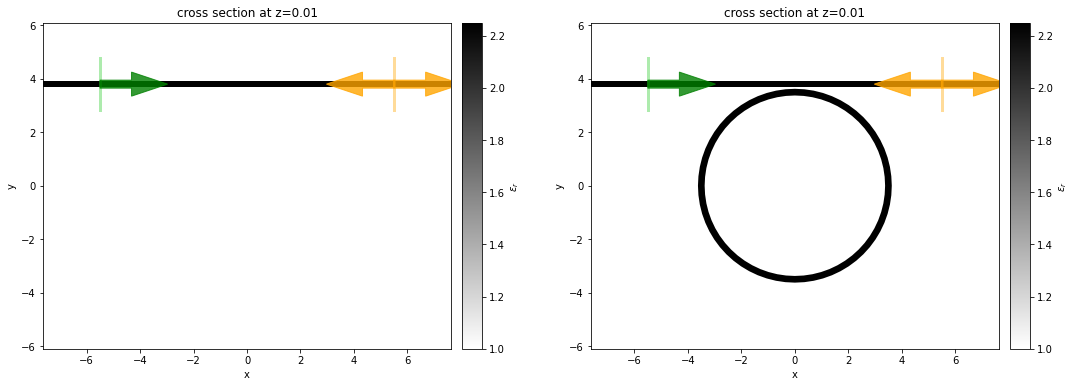

In [11]:
# plot the two simulations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sim0.plot_eps(z=0.01, ax=ax1)
sim.plot_eps(z=0.01, ax=ax2)
plt.show()

----
## Run Simulation
Run simulations on our server. [(docs)](https://docs.simulation.cloud/en/latest/api.html#submitting-simulations)

In [12]:
# use function above to run simulation with and without ring
sim_data0 = web.run(sim0, task_name='normalization', path='data/simulation_data0.hdf5')
sim_data = web.run(sim, task_name='with_ring', path='data/simulation_data.hdf5')

[14:10:35] INFO     Using Tidy3D credentials from stored file                      ]8;id=836094;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py\auth.py]8;;\:]8;id=36218;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py#74\74]8;;\

[14:10:37] INFO     Uploaded task 'normalization' with task_id                  ]8;id=280872;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=74492;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#117\117]8;;\
                    '1d53968d-1bcf-47b5-a39d-629afb5c7deb'.                                  

Output()

[14:10:38] INFO     status = queued                                             ]8;id=421988;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=753301;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#258\258]8;;\

Output()

[14:10:49] INFO     status = preprocess                                         ]8;id=895911;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=697175;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#270\270]8;;\

[14:10:50] INFO     Maximum flex unit cost: 0.10                                ]8;id=59966;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=160895;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#249\249]8;;\

[14:10:56] INFO     starting up solver                                          ]8;id=502160;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=55566;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[14:11:12] INFO     running solver                                              ]8;id=461659;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=847867;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#280\280]8;;\

Output()

[14:11:48] INFO     early shutoff detected, exiting.                            ]8;id=850119;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=531629;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#291\291]8;;\

           INFO     status = postprocess                                        ]8;id=689437;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=637328;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#297\297]8;;\

Output()

[14:12:05] INFO     status = success                                            ]8;id=762577;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=94231;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#303\303]8;;\

[14:12:06] INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=882418;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=982320;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#575\575]8;;\
                    "data/simulation_data0.hdf5"                                             

Output()

[14:12:08] INFO     loading SimulationData from data/simulation_data0.hdf5      ]8;id=999182;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=987086;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#397\397]8;;\

           INFO     Uploaded task 'with_ring' with task_id                      ]8;id=729752;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=356130;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#117\117]8;;\
                    '97333df3-0033-4666-9340-002480d193a4'.                                  

Output()

[14:12:10] INFO     status = queued                                             ]8;id=753164;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=959182;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#258\258]8;;\

Output()

[14:12:16] INFO     status = preprocess                                         ]8;id=127252;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=931792;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#270\270]8;;\

[14:12:22] INFO     Maximum flex unit cost: 0.12                                ]8;id=574486;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=211141;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#249\249]8;;\

           INFO     starting up solver                                          ]8;id=997319;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=483686;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[14:12:33] INFO     running solver                                              ]8;id=580591;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=618048;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#280\280]8;;\

Output()

[14:13:31] INFO     early shutoff detected, exiting.                            ]8;id=506594;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=269809;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#291\291]8;;\

           INFO     status = postprocess                                        ]8;id=58054;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=197301;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#297\297]8;;\

Output()

[14:13:50] INFO     status = success                                            ]8;id=606537;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=409467;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#303\303]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=736653;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=163033;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#575\575]8;;\
                    "data/simulation_data.hdf5"                                              

Output()

[14:13:54] INFO     loading SimulationData from data/simulation_data.hdf5       ]8;id=707350;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=570872;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#397\397]8;;\

In [13]:
print(sim_data0.log)

Simulation domain Nx, Ny, Nz: [1375, 741, 1]
Applied symmetries: (0, 0, 0)
Number of computational grid points: 1.0231e+06.
Using subpixel averaging: True
Number of time steps: 4.7330e+03
Automatic shutoff factor: 1.00e-05
Time step (s): 2.1135e-17


Compute source modes time (s):     0.2690
Compute monitor modes time (s):    3.4553
Rest of setup time (s):            5.0332

Running solver for 4733 time steps...
- Time step    189 / time 3.99e-15s (  4 % done), field decay: 1.00e+00
- Time step    377 / time 7.97e-15s (  7 % done), field decay: 1.00e+00
- Time step    378 / time 7.99e-15s (  8 % done), field decay: 1.00e+00
- Time step    567 / time 1.20e-14s ( 12 % done), field decay: 1.00e+00
- Time step    757 / time 1.60e-14s ( 16 % done), field decay: 9.96e-01
- Time step    946 / time 2.00e-14s ( 20 % done), field decay: 9.96e-01
- Time step   1135 / time 2.40e-14s ( 24 % done), field decay: 9.94e-01
- Time step   1325 / time 2.80e-14s ( 28 % done), field decay: 9.94e-01
- Time s

<Figure size 1080x720 with 8 Axes>

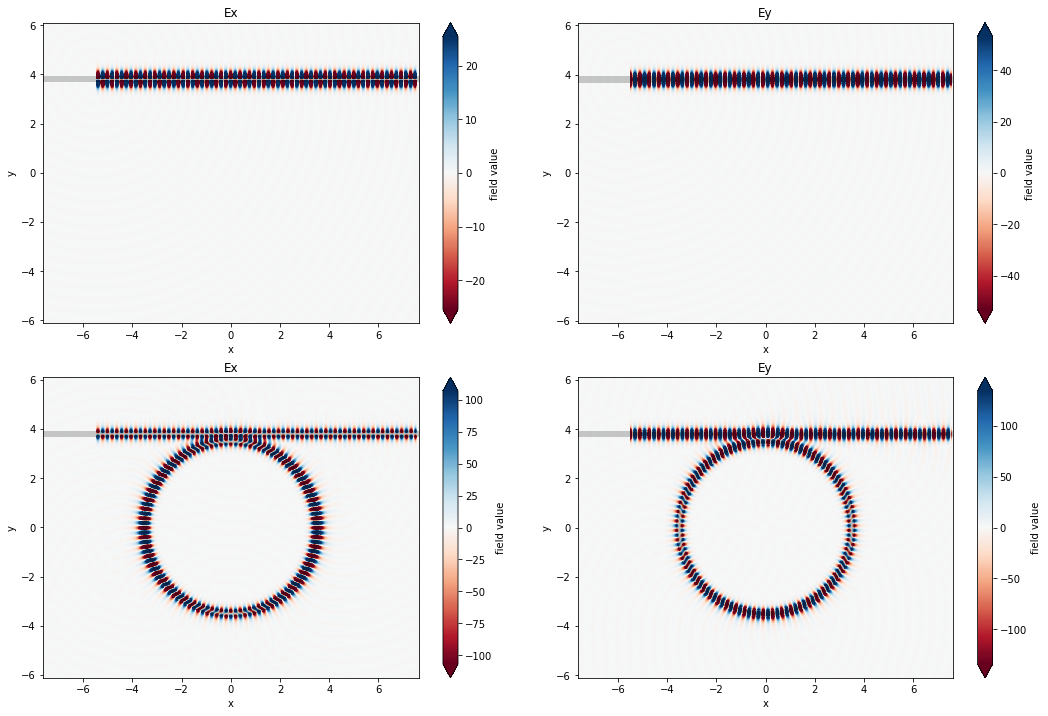

In [14]:
# visualize normalization run
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, tight_layout=True, figsize=(15, 10))

ax1 = sim_data0.plot_field('field', 'Ex', val='real', z=0, ax=ax1)
ax2 = sim_data0.plot_field('field', 'Ey', val='real', z=0, ax=ax2)
ax1.set_title('Ex')
ax2.set_title('Ey')

ax3 = sim_data.plot_field('field', 'Ex', val='real', z=0, ax=ax3)
ax4 = sim_data.plot_field('field', 'Ey', val='real', z=0, ax=ax4)
ax3.set_title('Ex')
ax4.set_title('Ey')

plt.show()

## Analyze Spectrum

Now let's analyze the mode amplitudes in the output waveguide.

First, let's grab the data to inspect it.

In [15]:
sim_data['mode']

ModeData(monitor=ModeMonitor(type='ModeMonitor', center=(5.5, 3.8, 0.0), size=(0.0, 2.0, inf), name='mode', freqs=(749481145327490.0, 749106592031474.2, 748732412914575.4, 748358607416365.4, 747985174977534.9, 747612115039890.2, 747239427046351.0, 746867110440946.6, 746495164668814.8, 746123589176197.0, 745752383410437.8, 745381546819980.1, 745011078854363.8, 744640978964222.5, 744271246601281.0, 743901881218352.2, 743532882269335.2, 743164249209211.6, 742795981494043.6, 742428078580970.8, 742060539928207.9, 741693364995042.0, 741326553241829.8, 740960104129995.0, 740594017122025.6, 740228291681471.5, 739862927272941.8, 739497923362101.5, 739133279415670.6, 738768994901419.4, 738405069288167.5, 738041502045780.4, 737678292645167.2, 737315440558278.4, 736952945258102.2, 736590806218663.4, 736229022915019.6, 735867594823259.6, 735506521420500.5, 735145802184884.8, 734785436595578.4, 734425424132768.2, 734065764277659.1, 733706456512471.9, 733347500320440.4, 732988895185809.2, 732630640593831.9, 732272736030766.9, 731915180983876.9, 731557974941425.1, 731201117392673.1, 730844607827879.1, 730488445738294.2, 730132630616161.6, 729777161954712.8, 729422039248165.4, 729067261991721.8, 728712829681565.2, 728358741814859.0, 728004997889742.6, 727651597405330.0, 727298539861707.9, 726945824759932.0, 726593451602026.1, 726241419890978.6, 725889729130740.9, 725538378826224.6, 725187368483299.4, 724836697608791.0, 724486365710478.5, 724136372297091.8, 723786716878310.0, 723437398964758.8, 723088418068007.6, 722739773700569.0, 722391465375893.9, 722043492608371.9, 721695854913326.9, 721348551807016.4, 721001582806628.1, 720654947430278.8, 720308645197011.0, 719962675626791.5, 719617038240508.9, 719271732559971.2, 718926758107904.0, 718582114407948.2, 718237800984657.4, 717893817363496.1, 717550163070837.8, 717206837633961.6, 716863840581052.1, 716521171441195.0, 716178829744376.5, 715836815021480.4, 715495126804286.4, 715153764625467.5, 714812728018588.5, 714472016518102.9, 714131629659352.0, 713791566978561.9, 713451828012841.5, 713112412300180.8, 712773319379448.4, 712434548790389.8, 712096100073624.6, 711757972770645.8, 711420166423815.9, 711082680576366.1, 710745514772394.5, 710408668556862.5, 710072141475594.5, 709735933075274.6, 709400042903445.2, 709064470508505.2, 708729215439706.8, 708394277247155.0, 708059655481804.5, 707725349695457.9, 707391359440764.5, 707057684271216.9, 706724323741150.4, 706391277405739.9, 706058544820998.5, 705726125543775.9, 705394019131755.2, 705062225143452.5, 704730743138213.5, 704399572676212.4, 704068713318450.0, 703738164626751.1, 703407926163763.5, 703077997492955.0, 702748378178612.2, 702419067785838.8, 702090065880552.8, 701761372029485.0, 701432985800177.9, 701104906760982.1, 700777134481056.5, 700449668530364.5, 700122508479673.0, 699795653900550.9, 699469104365366.2, 699142859447285.4, 698816918720270.4, 698491281759077.2, 698165948139254.8, 697840917437141.5, 697516189229865.0, 697191763095339.5, 696867638612264.0, 696543815360120.8, 696220292919173.1, 695897070870464.2, 695574148795814.4, 695251526277820.0, 694929202899851.6, 694607178246051.9, 694285451901333.9, 693964023451379.6, 693642892482637.6, 693322058582321.9, 693001521338409.6, 692681280339639.5, 692361335175510.4, 692041685436278.8, 691722330712958.0, 691403270597315.5, 691084504681871.8, 690766032559898.6, 690447853825416.8, 690129968073195.2, 689812374898748.2, 689495073898334.9, 689178064668956.4, 688861346808354.8, 688544919915011.5, 688228783588145.1, 687912937427709.9, 687597381034394.5, 687282114009619.4, 686967135955536.2, 686652446475025.2, 686338045171694.1, 686023931649876.4, 685710105514629.4, 685396566371733.0, 685083313827687.4, 684770347489712.1, 684457666965744.2, 684145271864436.2, 683833161795155.1, 683521336367980.0, 683209795193701.0, 682898537883817.8, 682587564050537.2, 682276873306772.9, 681966465266142.0, 681656339542965.0, 681346495752263.6, 681036933509759.1, 680727652431871.0, 680418652135715.0, 680109932

As we see, the mode amplitude data is complex-valued with three 3 dimensions:

- index into the mode order returned by solver (remember, we wanted mode_index=1 for fundamental TE).

- direction of the propagation (for decomposition).

- frequency.

Let's select into the first two dimensions to get mode amplitudes as a function of frequency and divide the results with a ring by the normalization.

In [16]:
mode_data = sim_data['mode'].amps.sel(mode_index=1, direction='+')
mode_data0 = sim_data0['mode'].amps.sel(mode_index=1, direction='+')
transmission_amps = mode_data / mode_data0

Now let's plot the data.

<Figure size 720x360 with 1 Axes>

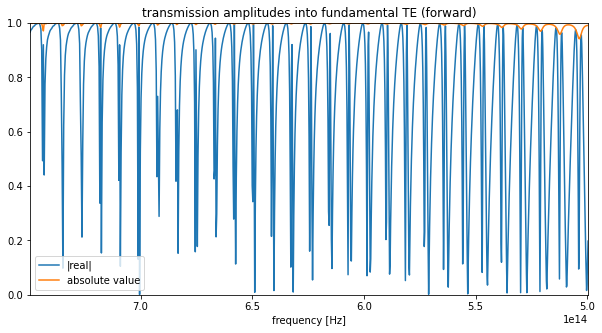

In [17]:
f, ax = plt.subplots(figsize=(10, 5))
abs(transmission_amps.real).plot.line(x='f', ax=ax, label='|real|')
# abs(transmission_amps.imag).plot.line(x='f', ax=ax, label='|imag|')
abs(transmission_amps).plot.line(x='f', ax=ax, label='absolute value')
ax.legend()
ax.set_title('transmission amplitudes into fundamental TE (forward)')
ax.set_ylim(0, 1)
ax.set_xlim(freqs_measure[0], freqs_measure[-1])
plt.show()